In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# get data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

68616192/68606236 [==============================] - 193s 3us/step


In [7]:
# split train and val
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# split val into test 80-20 
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Number of validation batches: 26
Number of test batches: 6


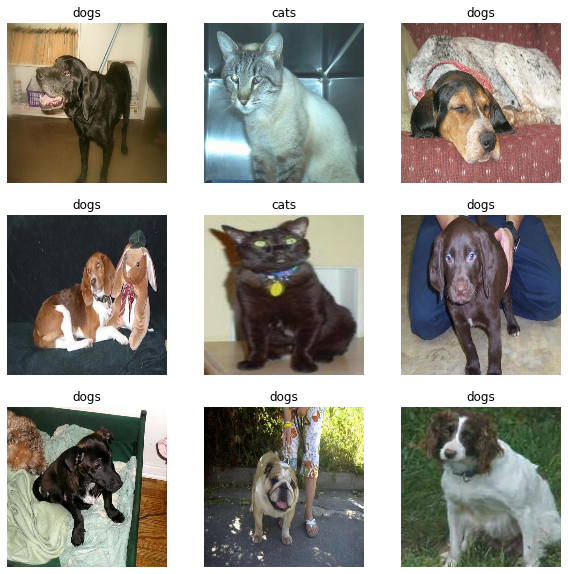

In [8]:
# Visualize 
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# performance enhancement
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Data augmentation (overfitting countermeasures)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

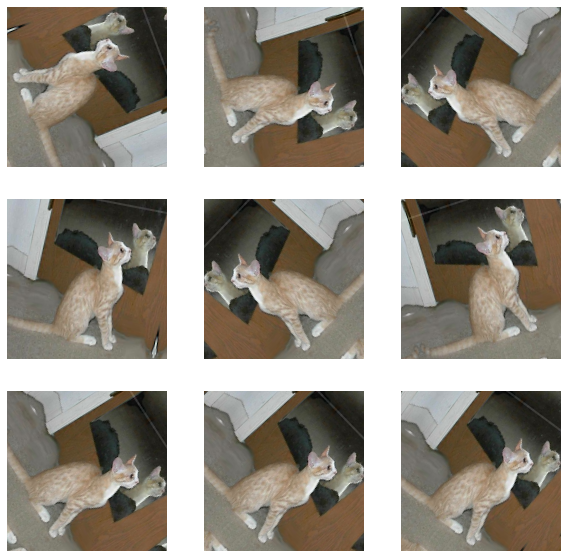

In [11]:
# Visualize data augmentation 
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [12]:
# Rescale pixel values 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [15]:
# Create basemodel from Google's MobileNetV2 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # This means don't include the classification layer 
                                               weights='imagenet')

9420800/9406464 [==============================] - 24s 3us/step


In [16]:
# Converts image in to a 5x5z1280 block of features 
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature Extraction

In [17]:
# Freeze the pre-trained model's weight from modification during training 
base_model.trainable = False

In [18]:
# Basemodel summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
# Adding classification head 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Squash the 5x5x1280 to just 1280 
feature_batch_average = global_average_layer(feature_batch) 
print(feature_batch_average.shape)

(32, 1280)


In [21]:
# add a dense layer to get output 
prediction_layer = tf.keras.layers.Dense(1) # negative values - class 0  ||||| pos values - class 1
prediction_batch = prediction_layer(feature_batch_average) # shrinks the 1280 features down to 1 (prediction)
print(prediction_batch.shape)

(32, 1)


In [22]:
# Build model
inputs = tf.keras.Input(shape=(160, 160, 3)) # Images 160x160 with RGB (x3 at the end)
x = data_augmentation(inputs)                # augment data (overfitting countermeasures)
x = preprocess_input(x)                      # Scale down images from 255 to the range [-1,1]
x = base_model(x, training=False)            # MobileNetV2 base model (not trainable)
x = global_average_layer(x)                  # squash 5x5x1280 features down to 1280 features 
x = tf.keras.layers.Dropout(0.2)(x)          # dropout (overfitting countermeasures)
outputs = prediction_layer(x)                # Dense layer to change 1280 features down to 1 prediction 
model = tf.keras.Model(inputs, outputs)      # Package all layers into a model

In [23]:
# compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [25]:
# Initial measurements 
initial_epochs = 10

# Initial model accuracy 
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 5s 167ms/step - loss: 0.8724 - accuracy: 0.4059
initial loss: 0.87
initial accuracy: 0.41


In [26]:
# Train 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 19s 272ms/step - loss: 0.7427 - accuracy: 0.5465 - val_loss: 0.5750 - val_accuracy: 0.6918
Epoch 2/10
63/63 [==============================] - 17s 267ms/step - loss: 0.5599 - accuracy: 0.6895 - val_loss: 0.4275 - val_accuracy: 0.8131
Epoch 3/10
63/63 [==============================] - 17s 268ms/step - loss: 0.4414 - accuracy: 0.7790 - val_loss: 0.3171 - val_accuracy: 0.8861
Epoch 4/10
63/63 [==============================] - 17s 271ms/step - loss: 0.3727 - accuracy: 0.8295 - val_loss: 0.2574 - val_accuracy: 0.9109
Epoch 5/10
63/63 [==============================] - 17s 275ms/step - loss: 0.3149 - accuracy: 0.8560 - val_loss: 0.2085 - val_accuracy: 0.9356
Epoch 6/10
63/63 [==============================] - 18s 283ms/step - loss: 0.2913 - accuracy: 0.8700 - val_loss: 0.1859 - val_accuracy: 0.9344
Epoch 7/10
63/63 [==============================] - 18s 285ms/step - loss: 0.2756 - accuracy: 0.8810 - val_loss: 0.1692 - val_accuracy: 0.9344

In [27]:
# Evauluate 
loss1, accuracy1 = model.evaluate(test_dataset)
print("after training loss: {:.2f}".format(loss1))
print("after training accuracy: {:.2f}".format(accuracy1))

6/6 [==============================] - 1s 197ms/step - loss: 0.1625 - accuracy: 0.9219
after training loss: 0.16
after training accuracy: 0.92


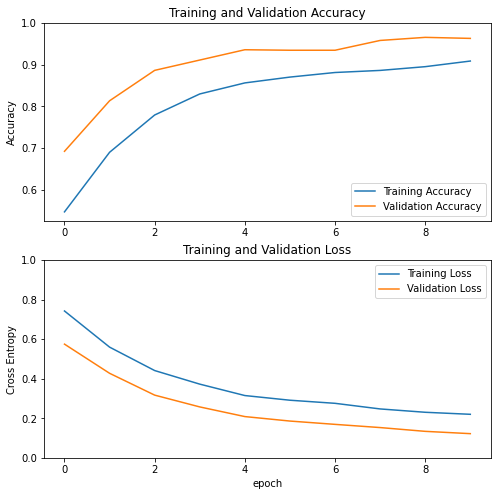

In [28]:
# Learning curves 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [29]:
# Weights of the top level base model layers were not tuned, can improve performance even more if we tune those 
base_model.trainable = True # unfreeze mobilenetv2 layers 

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards (freeze first 100 layers)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [31]:
# compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
# summary
model.summary()

# View trainable layers
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

56

In [34]:
# Train
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 28s 389ms/step - loss: 0.1736 - accuracy: 0.9245 - val_loss: 0.0702 - val_accuracy: 0.9678
Epoch 11/20
63/63 [==============================] - 24s 379ms/step - loss: 0.1253 - accuracy: 0.9480 - val_loss: 0.0478 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 24s 385ms/step - loss: 0.1104 - accuracy: 0.9555 - val_loss: 0.0449 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 25s 398ms/step - loss: 0.0967 - accuracy: 0.9610 - val_loss: 0.0478 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 25s 401ms/step - loss: 0.0823 - accuracy: 0.9685 - val_loss: 0.0355 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 25s 394ms/step - loss: 0.0932 - accuracy: 0.9635 - val_loss: 0.0328 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 24s 384ms/step - loss: 0.0786 - accuracy: 0.9690 - val_loss: 0.0439 - val_accuracy:

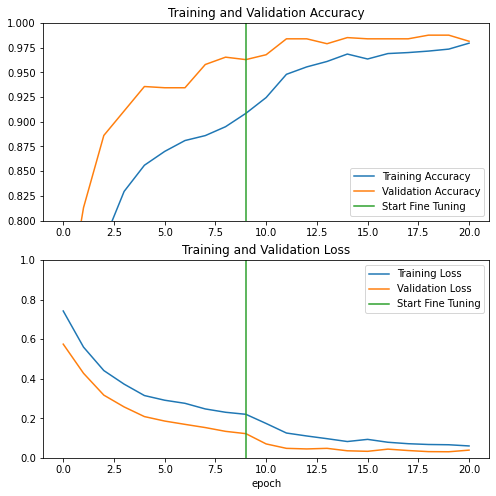

In [35]:
# Learning curves 
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Graph 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model Evaluation

In [37]:
# Model Evaluation
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy2)

6/6 [==============================] - 2s 245ms/step - loss: 0.0433 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


Predictions:
 [1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1]
Labels:
 [1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1]


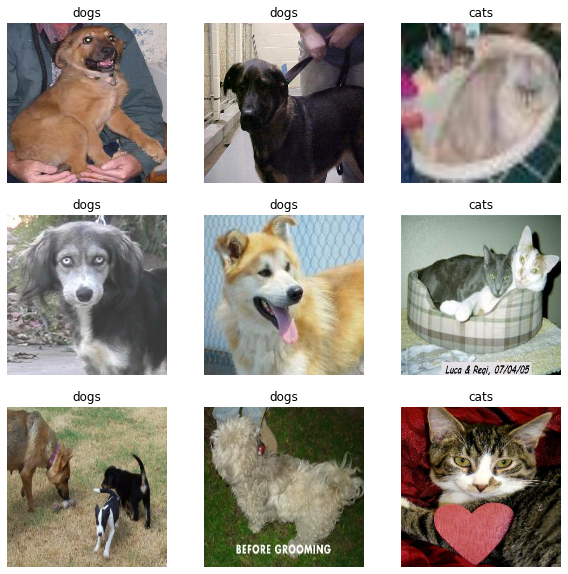

In [60]:
# predictions
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# Test on my dog 

In [119]:
# Get data
carter_dataset = tf.keras.utils.image_dataset_from_directory("./carter_images/",
                                                            shuffle=True,
                                                            image_size=IMG_SIZE)

Found 5 files belonging to 1 classes.


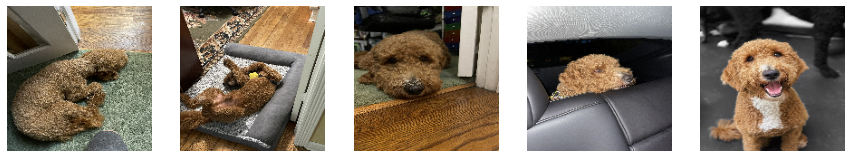

In [120]:
# Visualize
plt.figure(figsize=(15, 15))
i = 0
for batch,_ in iter(carter_dataset):
    for img in batch:
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow((img/255.))
        plt.axis('off')
        i += 1
plt.show()

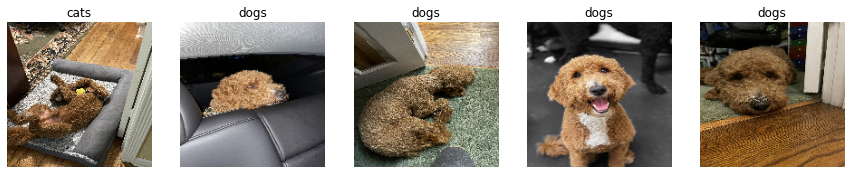

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 1, 1, 1], dtype=int32)>

In [121]:
# predict 
carter_pred = model.predict(carter_dataset)

# Get image 
carter_img, _ = carter_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(carter_img).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

# Plot 
plt.figure(figsize=(15, 15))
for i in range(5): 
    ax = plt.subplot(1,5,i+1)
    plt.imshow(carter_imgs[i])
    plt.title(class_names[predictions[i]])
    plt.axis("off")
plt.show()
predictions